In [20]:
import networkx as nx
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
from itertools import chain
from collections import defaultdict
from collections import Counter

class GerrymanderingSimulation:
    def __init__(self, M, N, strength):
        self.M = M
        self.N = N
        self.strength = 0.1
        
    def initialize(self):
        """
        creates a 10 by 10 grid of nodes
        each node has attributes:
            random number of people who vote A
            random number of people who vote B
            a population of vote_a + vote_b
            an original district number, which the node keeps throughout the districting process
            a district number, which is updated during the districting process
            a random number representing the distance from the next node
        
        """
        self.graph = nx.grid_2d_graph(self.M, self.N)

        for edge in list(self.graph.edges):
            self.graph.edges[edge]['strength'] = self.strength
            self.graph.edges[edge]['strength'] = self.strength

        for i, node in enumerate(list(self.graph.nodes)):
            self.graph.nodes[node]['original_district'] = i
            self.graph.nodes[node]['district'] = i
            self.graph.nodes[node]['distance'] = random.random()
            self.graph.nodes[node]['vote_a'] = random.randint(100,1000)
            self.graph.nodes[node]['vote_b'] = random.randint(100,1000)
            self.graph.nodes[node]['population'] = self.graph.nodes[node]['vote_a'] + self.graph.nodes[node]['vote_b']
            if self.graph.nodes[node]['population'] > 1750: #urban nodes more likely to vote A
                self.graph.nodes[node]['type'] = 0
                self.graph.nodes[node]['vote_a'] = int(round((self.graph.nodes[node]['vote_a']*1.1), 0))
            else: self.graph.nodes[node]['type'] = 1
        self.layout = nx.spring_layout(self.graph, k=1, iterations=1000)
        self.label_winner = None
        self.district_voted_a = []
        self.district_voted_b = []
        self.node_voted_a = []
        self.node_voted_b = []
        self.urban_nodes = []
        self.mean_population = []
        self.mean_efficiency_gap =[]
        
        
        
    def districting(self):
        
        current_node = random.choice(list(self.graph.nodes))
        neighbour_nodes_not_in_district = []

        for i in list(self.graph.adj[current_node]):
            if self.graph.nodes[i]['district'] != self.graph.nodes[current_node]['district']:
                neighbour_nodes_not_in_district.append(i)
        if len(neighbour_nodes_not_in_district) == 0:
            pass  
        elif len(neighbour_nodes_not_in_district) == 1:
            self.graph.nodes[neighbour_nodes_not_in_district[0]]['district'] = self.graph.nodes[current_node]['district']
        else:
            distances = [abs(self.graph.nodes[current_node]['distance'] - self.graph.nodes[neighbour]['distance']) for neighbour in neighbour_nodes_not_in_district]
            self.graph.nodes[neighbour_nodes_not_in_district[np.argmin(distances)]]['population'] = self.graph.nodes[current_node]['population']
            
    def voting(self):
    # find the population for each district
    # find the vote-a for each district
    # find the vote-b for each district
    # find total population, vote-a and vote-b
        district_population = {} # dictionary. district number: population
        
        original_district_no = [] #list of the original district numbers
        district_no = [] # list of the generated district numbers
        nodes_in_dists = []
        
        original_district_winner = {} # district: winner, a or b. for original districts
        district_winner = {} # district: winner, a or b. for generated districts
        
        original_number_of_votes_a = {} # district: number of people who voted a for original districts
        original_number_of_votes_b = {} # district: number of people who voted b for original districts
        number_of_votes_a = {} # district: number of people who voted a for generated districts
        number_of_votes_b = {} # district: number of people who voted b for generated districts
        
        district_node_votes_a = {}
        district_node_votes_b = {}

        
        '''original districts'''
        
        
        for i in set([info['original_district'] for node, info in sim.graph.nodes.data()]):
            original_district_no.append(i) 
        
        # if this district has not yet been recorded, then add the district number as a key,
        # and it's votes as values, to the list of districts
        # if it has been added, then add the votes to the values already associated with the district
        
        for x in list(self.graph.nodes):
            if self.graph.nodes[x]['type'] == 0:
                self.urban_nodes.append(self.graph.nodes[x]['original_district'])
            original_district = self.graph.nodes[x]['original_district']
            if original_district not in original_number_of_votes_a:
                original_number_of_votes_a[original_district] = self.graph.nodes[x]['vote_a']
                original_number_of_votes_b[original_district] = self.graph.nodes[x]['vote_b']
            else:
                original_number_of_votes_a[original_district] += self.graph.nodes[x]['vote_a']
                original_number_of_votes_b[original_district] += self.graph.nodes[x]['vote_b']

            
        #assigns a winner, a or b, to each original district
        #and creates a list of the original districts which voted for A
        #and a list of the original districts which voted for B.
        for d in original_district_no:
            if original_number_of_votes_a[d] > original_number_of_votes_b[d]:
                original_district_winner[d] = 'A'
            else: original_district_winner[d] = 'B'
        for key, value in original_district_winner.iteritems():
            if 'A' == value:
                self.node_voted_a.append(key)
            else:
                self.node_voted_b.append(key)
                
        '''generated districts'''
                
        #find the total population and number of votes for a and b in each district (used to calculate efficiency gap)        
        for i in set([info['district'] for node, info in sim.graph.nodes.data()]):
            district_no.append(i)
            
        # if this district has not yet been recorded, then add the district number as a key
        # and it's votes as values, to the list of districts
        # if it has been added, then add the votes to the values already associated with the district
        for x in list(self.graph.nodes):
            district = self.graph.nodes[x]['district']
            if district not in district_population:
                district_population[district] = self.graph.nodes[x]['population']
                number_of_votes_a[district] = self.graph.nodes[x]['vote_a']
                number_of_votes_b[district] = self.graph.nodes[x]['vote_b']
            else:
                district_population[district] += self.graph.nodes[x]['population']
                number_of_votes_a[district] += self.graph.nodes[x]['vote_a']
                number_of_votes_b[district] += self.graph.nodes[x]['vote_b']
                
                
        # find the winner for the node, and then find how many nodes voted a in each district
        # district winner is the majority of node votes
        # so if there are 1000 people, and 600 of them vote b
        # but there are 10 nodes and 6 of them voted a
        # then a wins
        
        for x in list(self.graph.nodes):
            if self.graph.nodes[x]['vote_a'] > self.graph.nodes[x]['vote_b']:
                if self.graph.nodes[x]['district'] in district_node_votes_a:
                    district_node_votes_a[self.graph.nodes[x]['district']] += 1
                else:
                    district_node_votes_a[self.graph.nodes[x]['district']] = 1
                    district_node_votes_b[self.graph.nodes[x]['district']] = 0
            else:
                if self.graph.nodes[x]['district'] in district_node_votes_a:
                    district_node_votes_b[self.graph.nodes[x]['district']] += 1
                else:
                    district_node_votes_a[self.graph.nodes[x]['district']] = 0
                    district_node_votes_b[self.graph.nodes[x]['district']] = 1
                
        
        #assigns a winner, a or b, to each district
        #creates a list of the nodes within each district which voted for A
        #and a list of the nodes within each district which voted for B.
        
        in_district_node_votes = defaultdict(list)
        for k, v in chain(district_node_votes_a.items(), district_node_votes_b.items()):
            in_district_node_votes[k].append(v)
        
        # district winner is determined by the node winners, not the individual voters
        for k, v in in_district_node_votes.items():
            if v[0] > v[1]:
                district_winner[k] = 'A'
            elif v[0] < v[1]:
                district_winner[k] = 'B'
            else: district_winner[k] = random.choice(['A', 'B']) #if there is a tie, the winner is randomly selected
      
  
        for key, value in district_winner.iteritems():
            if 'A' == value:
                self.district_voted_a.append(key)
            else:
                self.district_voted_b.append(key)
        
        # label the nodes according to their generated district. used in observe function
        self.label_winner = {node: district_winner[self.graph.nodes[node]['district']] for node in self.graph.nodes}
        
        
        '''Analysis'''
        
        # Finding the efficiency gap
        
            # lost votes = total votes for their team if they lost, and 0 if they won
            # excess votes = total votes for their team - population of district/2 if they won, and 0 if they lost
            # wasted votes = lost votes if they lost, and excess votes if they won
            # efficiency gap = discrepancy between wasted votes for A and wasted votes for B/population
        
        
        wasted_votes_a = {}
        wasted_votes_b = {}
        efficiency_gap = {}
        
        for district in district_no:
            if district in self.district_voted_b: #b wins
                if district not in wasted_votes_b:
                     wasted_votes_b[district] = (number_of_votes_b[district] - (district_population[district]/2))
                else: wasted_votes_b[district] += (number_of_votes_b[district] - (district_population[district]/2))
                wasted_votes_a[district] = number_of_votes_a[district] 
                    
                    
            elif district in self.district_voted_a: #a wins
                if district not in wasted_votes_a:
                     wasted_votes_a[district] = (number_of_votes_a[district] - (district_population[district]/2))
                else: wasted_votes_a[district] += (number_of_votes_a[district] - (district_population[district]/2))
                wasted_votes_b[district] = number_of_votes_b[district]
        
        for district, value in district_population.iteritems():
            efficiency_gap[district] = (float(abs(wasted_votes_b[district] - wasted_votes_a[district]))/value)
        
        self.mean_efficiency_gap.append(sum(efficiency_gap.values())/len(efficiency_gap.values()))

        # Finding the Expected vs Actual wins
        
            # expected a wins is the number of nodes we expect A to win if we don’t do any districting 
            # we then change the node's vote based on it’s district
            # now the actual number that a wins is based on the district votes
            # then we find the difference between expected and actual
            # the net difference is the number of nodes that would need to change in order for the
            # districted model to accurately reflect the population vote
        
            # expected_a_wins = number_of_votes_a/district_population * number_of_nodes_in_district
            

        nodes_dist_0 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[0]:
                nodes_dist_0.append(p)
        nodes_dist_1 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[1]:
                nodes_dist_1.append(p)
        nodes_dist_2 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[2]:
                nodes_dist_2.append(p)
        nodes_dist_3 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[3]:
                nodes_dist_3.append(p)
        nodes_dist_4 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[4]:
                nodes_dist_4.append(p)
        nodes_dist_5 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[5]:
                nodes_dist_5.append(p)
        nodes_dist_6 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[6]:
                nodes_dist_6.append(p)
        nodes_dist_7 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[7]:
                nodes_dist_7.append(p)
        nodes_dist_8 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[8]:
                nodes_dist_8.append(p)
        nodes_dist_9 = []
        for (p, d) in sim.graph.nodes(data=True):
            if d['district'] == district_no[9]:
                nodes_dist_9.append(p)
        
        nodes_dist_all = []
        nodes_dist_all.append(len(nodes_dist_0))
        nodes_dist_all.append(len(nodes_dist_1))
        nodes_dist_all.append(len(nodes_dist_2))
        nodes_dist_all.append(len(nodes_dist_3))
        nodes_dist_all.append(len(nodes_dist_4))
        nodes_dist_all.append(len(nodes_dist_5))
        nodes_dist_all.append(len(nodes_dist_6))
        nodes_dist_all.append(len(nodes_dist_7))
        nodes_dist_all.append(len(nodes_dist_8))
        nodes_dist_all.append(len(nodes_dist_9))

        number_of_nodes_in_district = dict(zip(district_no, nodes_dist_all))
        
        calculation_a = defaultdict(list)
        for k, v in chain(number_of_votes_a.items(), district_population.items(), number_of_nodes_in_district.items()):
            calculation_a[k].append(v)
        
        expected_a_by_district = {}
        for k, v in calculation_a.items():
            expected_a_by_district[k] = int(round((float(v[0])/float(v[1]) * v[2]), 0))
        
        expected_a_wins = sum(expected_a_by_district.itervalues())

        districts_where_a_wins = [k for k,v in district_winner.iteritems() if v == "A"]

        actual_a_wins_list = []
        
        for i in range(0, len(districts_where_a_wins)):
            actual_a_wins_list.append(number_of_nodes_in_district.get(districts_where_a_wins[i]))

        actual_a_wins = sum(actual_a_wins_list)
        
        expected_b_wins = 100 - expected_a_wins
        actual_b_wins = 100 - actual_a_wins
        
        
        # return True if A wins in district model, return True if A wins in nodel model
        return len(self.district_voted_a) > len(self.district_voted_b), len(self.node_voted_a) > len(self.node_voted_b), self.urban_nodes, (actual_a_wins - expected_a_wins)  
    
    
    def observe(self):
        label_dist_number = nx.get_node_attributes(sim.graph, 'district')
        dists = []
        color_map = []
        edgecolors = []
        for i in set([info['district'] for node, info in sim.graph.nodes.data()]):
            dists.append(i)
        for node in sim.graph:
            if self.graph.nodes[node]['district'] == dists[0]:
                color_map.append('lawngreen')
            elif self.graph.nodes[node]['district']== dists[1]:
                color_map.append('lightgreen')
            elif self.graph.nodes[node]['district'] == dists[2]:
                color_map.append('mediumaquamarine')
            elif self.graph.nodes[node]['district'] == dists[3]:
                color_map.append('deepskyblue')
            elif self.graph.nodes[node]['district'] == dists[4]:
                color_map.append('dodgerblue')
            elif self.graph.nodes[node]['district'] == dists[5]:
                color_map.append('orchid')
            elif self.graph.nodes[node]['district'] == dists[6]:
                color_map.append('yellowgreen')
            elif self.graph.nodes[node]['district']== dists[7]:
                color_map.append('purple')
            elif self.graph.nodes[node]['district']== dists[8]:
                color_map.append('mediumslateblue')
            elif self.graph.nodes[node]['district']== dists[9]:
                color_map.append('blue')
        for n, node in enumerate(sim.graph):
            if self.graph.nodes[node]['type'] == 0:
                edgecolors.append('black')
            else: 
                edgecolors.append(color_map[n])
        if self.label_winner:
            nx.draw(self.graph, self.layout, node_color=color_map, node_size = 300, labels=self.label_winner, font_color="white", font_weight="bold")
            nx.draw_networkx_nodes(self.graph, self.layout, node_color=color_map, edgecolors = edgecolors, labels=self.label_winner, font_color="white", font_weight="bold")
            plt.title('Example Districting with Votes')
            plt.show()

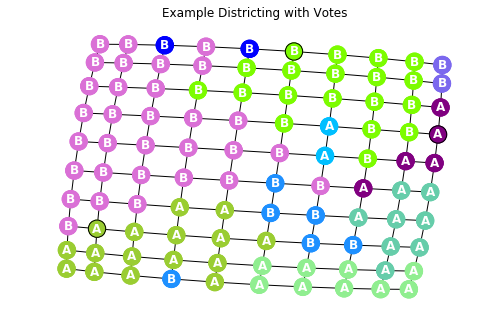

Graph Information:
In the districted model, A won in  493 % of cases when we ran 100 trials
In the undistricted model, A won in  590 % of cases when we ran 100 trials


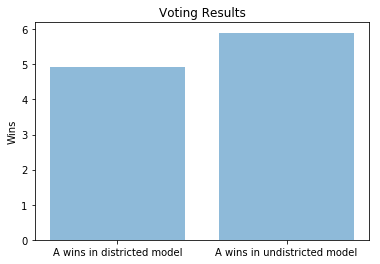

Analysis:
Average underrepresentation of A in district wins vs population vote: 6
Average overrepresentation of A in district wins vs population vote: 8
Change in nodes won in order for the districted model to lead to the same result as the population vote: -3


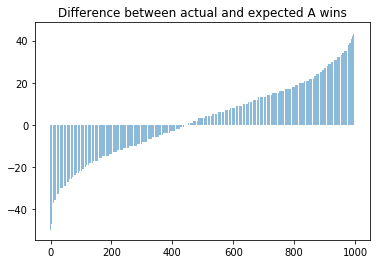

Average Efficiency Gap in District Model: 38.67 %


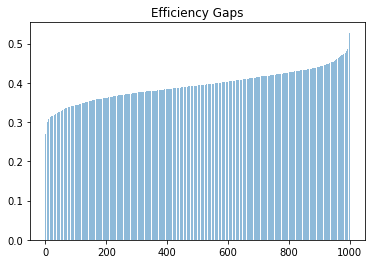

In [33]:
total_a_district_wins = 0
total_a_node_wins = 0
total_urban_nodes = 0
mean_efficiency_gaps = []
differences = []
underrepresentation = 0
overrepresentation = 0


for i in range(1000):

    sim = GerrymanderingSimulation(10,10, 0.1)
    sim.initialize()
    while len(set([info['district'] for node, info in sim.graph.nodes.data()])) >10:
        sim.districting()
    outcomes = sim.voting()
    if i == 1:
        sim.observe()

    total_a_district_wins += outcomes[0]
    total_a_node_wins += outcomes[1]
    total_urban_nodes += len(outcomes[2])
    differences.append(outcomes[3])
    mean_efficiency_gaps.append(sim.mean_efficiency_gap[0])

for x in differences: # differences is a list of the (actual_a_wins - expected_a_wins) for each simulation
    if x < 0:
        underrepresentation += x
    else:
        overrepresentation += x

net_difference = abs(underrepresentation) - overrepresentation
        
print 'Graph Information:' 
print 'In the districted model, A won in ',total_a_district_wins, '% of cases when we ran 100 trials'
print 'In the undistricted model, A won in ',total_a_node_wins, '% of cases when we ran 100 trials'


objects = ('A wins in districted model', 'A wins in undistricted model')
y_pos = np.arange(len(objects))
wins = [total_a_district_wins/100.0, total_a_node_wins/100.0]
 
plt.bar(y_pos, wins, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wins')
plt.title('Voting Results')
 
plt.show()

print 'Analysis:'

print 'Average underrepresentation of A in district wins vs population vote:', abs(underrepresentation)/1000
print 'Average overrepresentation of A in district wins vs population vote:', overrepresentation/1000
print 'Change in nodes won in order for the districted model to lead to the same result as the population vote:', net_difference /1000


y = sorted(differences)
N = len(differences)
x = range(N)
plt.bar(x, y, align='center', alpha=0.5)
plt.title('Difference between actual and expected A wins')

plt.show()

print 'Average Efficiency Gap in District Model:', round(sim.mean_efficiency_gap[0]*100, 2), '%'
t = sorted(mean_efficiency_gaps)
R = len(mean_efficiency_gaps)
s = range(R)
plt.bar(s, t, align='center', alpha=0.5)
plt.title('Efficiency Gaps')

plt.show()

